In [1]:
%load_ext autoreload
%autoreload 2

# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = 'all'

In [2]:
import numpy as np
import json
from random import sample

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

In [3]:
import torch
import torch.nn.functional as F

from transformers import *

In [4]:
models = {}

In [5]:
model_class, tokenizer_class, shortcut, mask_token = RobertaForMaskedLM, RobertaTokenizer, 'roberta-base', '<mask>'
model, tokenizer = model_class.from_pretrained(shortcut), tokenizer_class.from_pretrained(shortcut)
models[shortcut] = (model, tokenizer, mask_token)

loading state_dict took 0.812 sec


Some weights of RobertaForMaskedLM were not initialized from the model checkpoint at roberta-base and are newly initialized: ['lm_head.decoder.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
model_class, tokenizer_class, shortcut, mask_token = RobertaForMaskedLM, RobertaTokenizer, 'roberta-large', '<mask>'
model, tokenizer = model_class.from_pretrained(shortcut), tokenizer_class.from_pretrained(shortcut)
models[shortcut] = (model, tokenizer, mask_token)

loading state_dict took 1.546 sec


Some weights of RobertaForMaskedLM were not initialized from the model checkpoint at roberta-large and are newly initialized: ['lm_head.decoder.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
model_class, tokenizer_class, shortcut, mask_token = GPT2LMHeadModel, GPT2Tokenizer, 'gpt2', None
model, tokenizer = model_class.from_pretrained(shortcut), tokenizer_class.from_pretrained(shortcut)
models[shortcut] = (model, tokenizer, mask_token)

loading state_dict took 1.134 sec


TypeError: 'dict' object is not callable

In [21]:
model_class, tokenizer_class, shortcut, mask_token = GPT2LMHeadModel, GPT2Tokenizer, 'gpt2-large', None
model, tokenizer = model_class.from_pretrained(shortcut), tokenizer_class.from_pretrained(shortcut)
models[shortcut] = (model, tokenizer, mask_token)

In [48]:
model_class, tokenizer_class, shortcut, mask_token = GPT2LMHeadModel, GPT2Tokenizer, 'gpt2-xl', None
model, tokenizer = model_class.from_pretrained(shortcut), tokenizer_class.from_pretrained(shortcut)
models[shortcut] = (model, tokenizer, mask_token)

In [8]:
model, tokenizer, mask_token = models['roberta-large']

In [9]:
import re
import pandas as pd
import collections
import os
import nltk
import random

In [79]:
# 处理同位词->co-hyponym_dict
# am-for-bert
am_for_bert = 'am_for_bert.txt'
with open(am_for_bert, 'r') as f:
    file_lines = f.readlines()

keymap =  [re.split(' |\t',string) for string in file_lines]
am_for_bert_cohyponym = {}
           
for item in keymap:
           # 筛选出同位词
    if ('cohyponym' == item[4]):
        master = item[2]
        slave = []
        length = len(item)
        
        for i in range(int((length-5)/2)):
            slave.append(item[5+i*2])
        
        am_for_bert_cohyponym[master] = slave
        
#print(len(am_for_bert_cohyponym))

# sim-eval/bless
filename = 'sim_eval_bless.csv'
file_colname=['word1','word2','relation']
df = pd.read_csv(filename,header=None,names=file_colname,sep = ';') 
df_clean = df[df['relation'].str.contains('coord')]      
cohyponym = df_clean.groupby(['word1'])['word2'].apply(list).to_dict()
#print(len(cohyponym))
           
# 合并数据集
co_hyponym_dict = {}
co_hyponym_dict.update(am_for_bert_cohyponym)
co_hyponym_dict.update(cohyponym)
#print(co_hyponym_dict)
#print(random.sample(list(co_hyponym_dict), 500))
i = 0

for key in co_hyponym_dict.keys():
    print(key)
    print(':')
    print(co_hyponym_dict[key])
    i = i+1
    if i>100:
        break


school
:
['house', 'church', 'college', 'center', 'hospital', 'hotel', 'ministry', 'restaurant', 'palace', 'temple', 'architecture', 'residence', 'theater', 'ruin', 'villa', 'embassy', 'cinema', 'garage', 'cabin', 'casino', 'chapel', 'cafe', 'mansion', 'mosque', 'abbey', 'capitol', 'barn', 'observatory', 'monastery', 'shrine', 'kirk', 'greenhouse', 'manor', 'oracle', 'convent', 'consulate', 'courthouse', 'synagogue', 'tavern', 'motel', 'hostel', 'preschool', 'diner', 'rink', 'farmhouse', 'chateau', 'basilica', 'bungalow', 'clubhouse', 'conservatory']
city
:
['state', 'country', 'town', 'department', 'county', 'kingdom', 'ward', 'commonwealth', 'reservation', 'hometown', 'township', 'borough', 'canton', 'commune', 'shire', 'prefecture', 'barrio', 'sultanate']
state
:
['city', 'country', 'town', 'department', 'county', 'ward', 'reservation', 'municipality', 'hometown', 'township', 'borough', 'canton', 'commune', 'shire', 'prefecture']
university
:
['office', 'prison', 'shop', 'joint', 'j

In [64]:
# 把dict的词替换到句子模板
templates = [
    'A * _ and a * = are of the same kind .',
    'The co-hyponym for * _ is * = .',
    'When it comes to * _ , I think of * = .',
    '* _ and * = belong to the same subcategory .'
]
texts = []
one = templates[1]
for (key,value) in co_hyponym_dict.items():
    for word in value:
        example = one.replace('_', key).replace('=', word)
        texts.append(example)
#print(texts[8:20])
print(len(texts)) 


313048


In [65]:
# 得到attention值
# 随机抽样5000条
texts = random.sample(texts, 3000)
all_attn_probs, idx_pairs, tokenses = [], [], []
for text in tqdm(texts):
    if mask_token is not None:
        text = text.replace(' _ ', ' %s ' % mask_token)
    tokens = tokenizer.convert_ids_to_tokens(tokenizer.encode(text, add_special_tokens=True))
    tokens = ['*' if token in ['*', 'Ġ*'] else token for token in tokens]
    marker = '*'
    if marker in tokens:
        assert tokens.count(marker) == 2, str(tokens)
        p, h = [i for i, token in enumerate(tokens) if token == marker]
        tokens = [token for token in tokens if token != marker]
        h -= 1
        #print(tokens[p], tokens[h])
    token_ids = tokenizer.convert_tokens_to_ids(tokens)
    pred_idx = [i for i, token in enumerate(tokens) if token == mask_token] if mask_token is not None else [-1]
    tokens = ['@' + token if not token.startswith('Ġ') and token not in ['<s>', '</s>', '<mask>'] else token.replace('Ġ', '') 
              for token in tokens] 
    #print(tokens)
    
    input_ids = torch.tensor([token_ids])
    with torch.no_grad():
        logits, attns = model(input_ids, output_attentions=True)
        probs = F.softmax(logits, dim=-1)

    attn_scores, attn_probs = zip(*attns)
    attn_scores, attn_probs = torch.cat(attn_scores, dim=0), torch.cat(attn_probs, dim=0)
    all_attn_probs.append(attn_probs)
    idx_pairs.append((p, h))
    tokenses.append(tokens)
    #print("===============================")
   # print(tokenses)
    #print(idx_pairs)
    #print(attn_probs[0, 0, 1, 1])
   # print(attn_probs[:, :, h, p])

# 求注意力值的平均值
attn_sum = np.zeros((24, 16),dtype='float32')
i = 0
for attn_one, (p, h) in zip(all_attn_probs, idx_pairs):    
    attn_every = np.array(attn_one[:, :, h, p])
   #求和
    attn_sum += attn_every
   # 记录总共有多少句子来求平均
    i = i+1
#sum = attn_sum.tolist()
#求平均
attn_average = attn_sum/i
average = attn_average.tolist()
#print(average)

100%|██████████| 3000/3000 [12:02<00:00,  4.15it/s]


Text(0.5, 33.0, 'Average-co-hyponym-head')

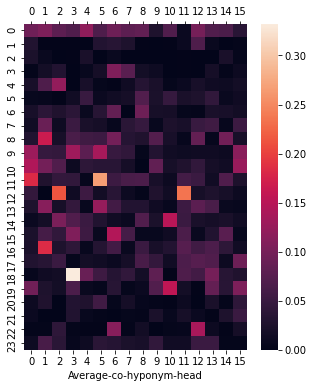

In [25]:
# 算平均后的head图
fig = plt.subplots(1,1,sharey=False, figsize=(5 , 6))
ax = sns.heatmap(attn_average)
ax.tick_params(top=True, labeltop=True)
ax.set_xlabel('Average-co-hyponym-head')

<AxesSubplot:>

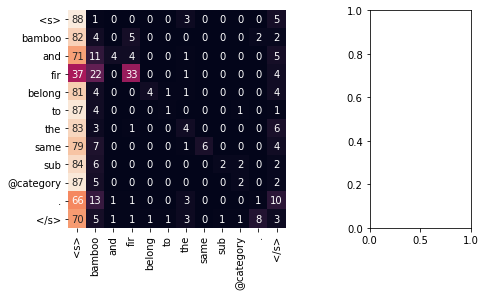

In [63]:
i = 1234
layer, head = 11, 5
attn = all_attn_probs[i][layer, head]
tokens = tokenses[i]
size = round(attn.size(0) / 3)
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(size  * 2., size), gridspec_kw={'width_ratios': [3, 1]})
sns.heatmap((attn * 100).long(), square=True, cbar=False, annot=True, fmt='d', xticklabels=tokens, yticklabels=tokens, ax=ax0)